# Milk And Honey V2?

HIT Final project in computer data science by Chen Einy and Gal Natan.


# Table of Contents

- ## Abstract
- ## Introduction
- ## Data Collection
    - ### Web Scraping
    - ### API Integration
- ## Data Preprocessing
    - ### Handling Missing Values
    - ### Removing Duplicates
    - ### Data Transformation
- ## Exploratory Data Analysis (EDA)
    - ### Data Visualization
- ## Machine Learning
    - ### Feature Engineering
    - ### Model Selection
    - ### Model Training and Evaluation
- ## Conclusion



## Abstract

Predicting Award-Winning Whiskies: Unraveling the Secrets of Master Of Malt Website

In this project, we delve into the world of whiskies and embark on a journey to uncover the factors that contribute to the recognition of award-winning whiskies. By harnessing the power of web scraping techniques and employing advanced machine learning methods, we aim to predict whether a whisky has the potential to be an award winner based on data gathered from the esteemed Master Of Malt website. Through this exploration, we seek to unravel the hidden patterns and insights that influence the distinction between exceptional whiskies and their counterparts. Join us as we unlock the secrets of the whisky industry and shed light on what sets award-winning whiskies apart.


# Importing Libraries


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import geopandas as gpd
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from wordcloud import WordCloud
from nltk.corpus import stopwords

import requests
import os
from bs4 import BeautifulSoup
import threading
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import winsound
import queue
from selenium.common.exceptions import WebDriverException


## Data Acquisition
sources/credits: [Selenium Python Documentation](https://selenium-python.readthedocs.io/index.html)

# Web Scraping

In this section we use selenium to crawl through https://www.masterofmalt.com/ and scrape all the Whiskied Data.

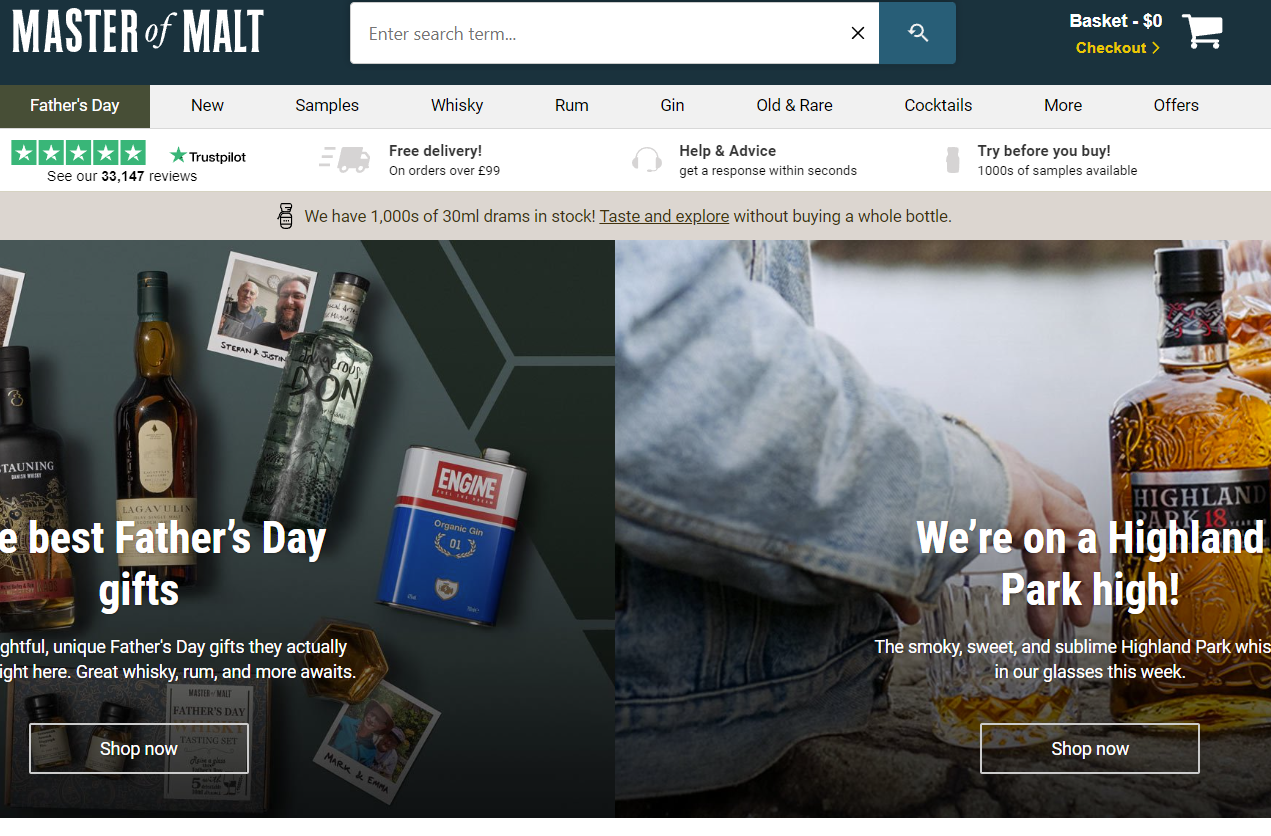
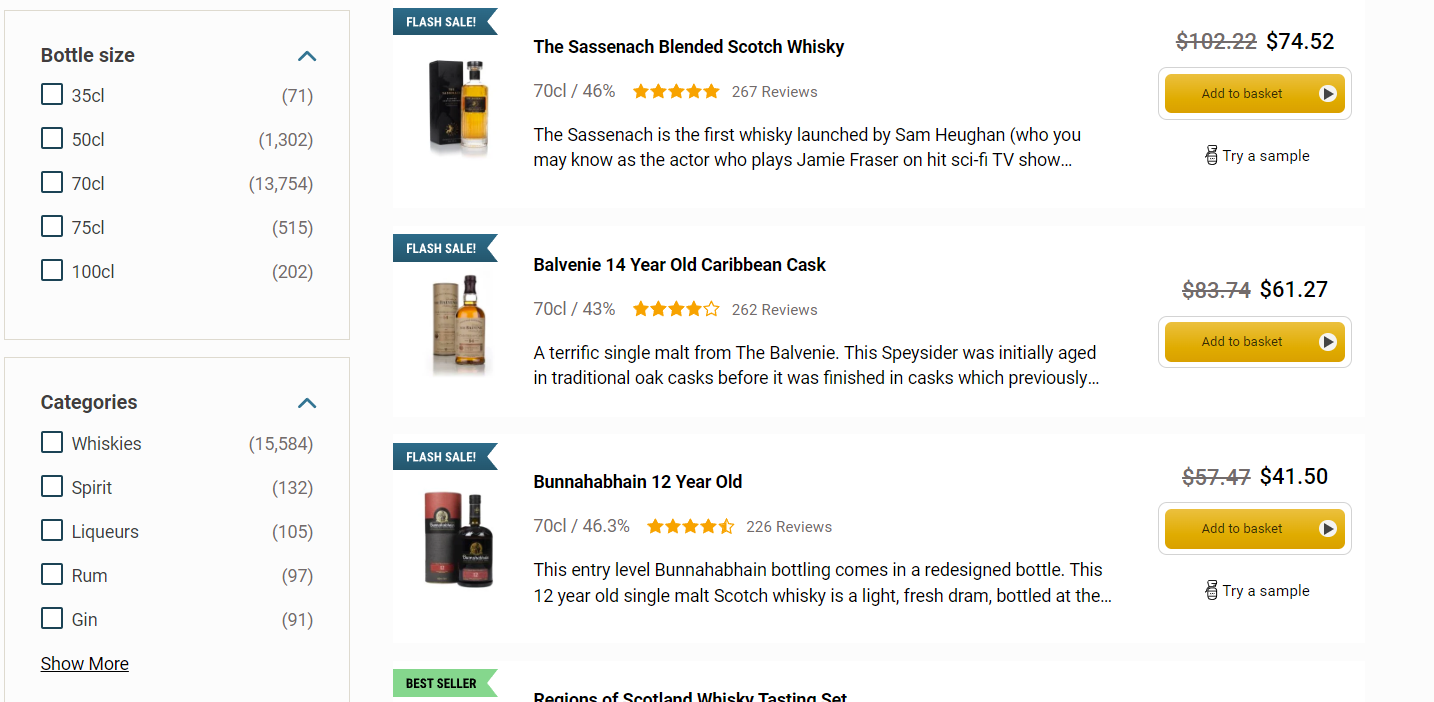
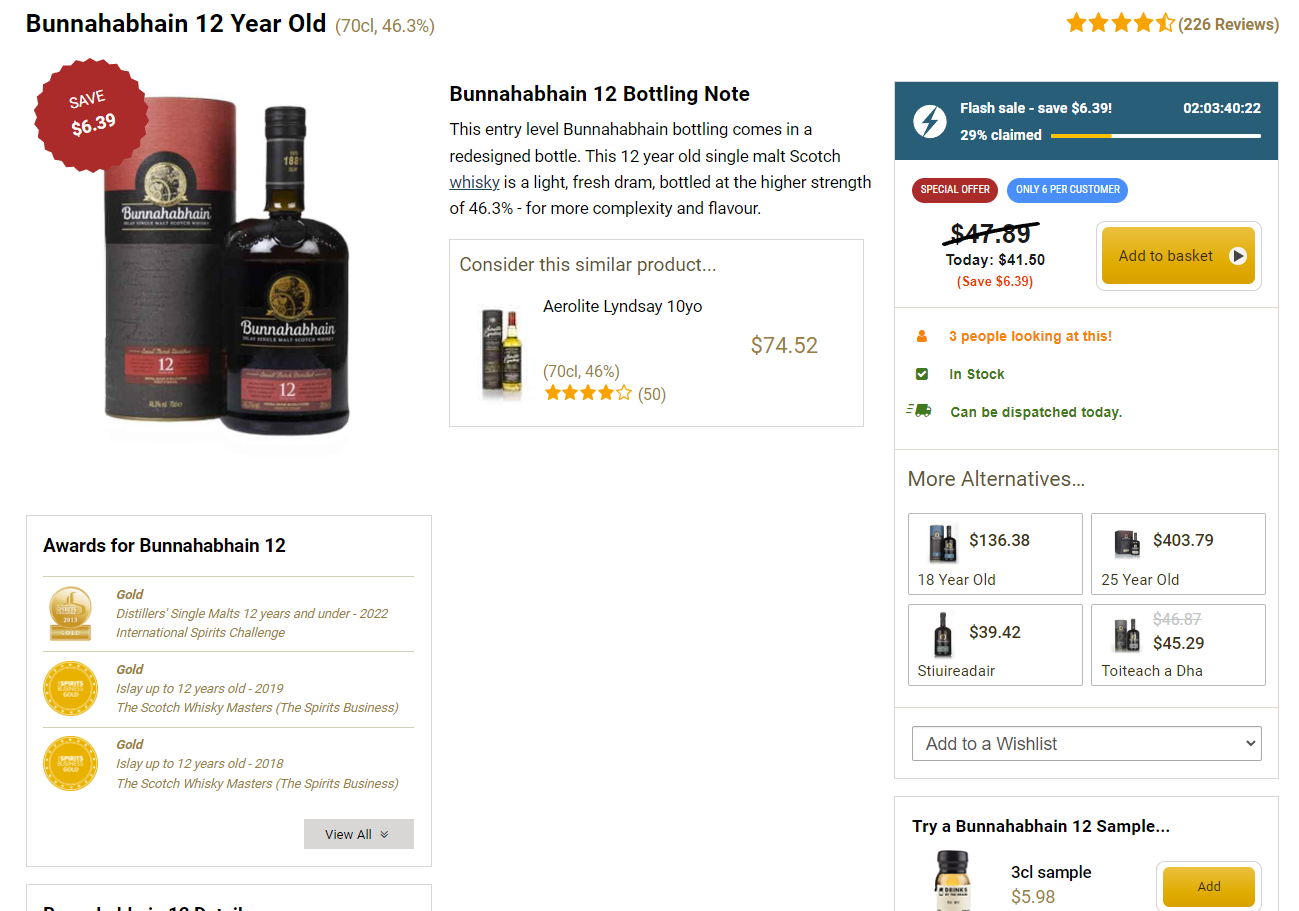

In [2]:
link_loop_lock = threading.Lock()

result_queue_lock = threading.Lock()


def link_loop(links, result_queue):
    max_retries = 3
    retries = 0
    gather_data_list = []
    for link in links:
        while retries < max_retries:
            try:
                print(link)
                curr_sm = load_soup(link)
                sm_data = gather_data_from_item(curr_sm)

                with result_queue_lock:
                    gather_data_list.append(pd.DataFrame(sm_data, index=[0]))
                break
            except WebDriverException as e:
                print(f"Failed to load soup: {e}")
                retries += 1
                if retries < max_retries:
                    print("Retrying...")
                    time.sleep(1)
                else:
                    print("Max retries reached. Moving to the next link.")
    with result_queue_lock:
        result_queue.put(gather_data_list)


def gather_awards(soup):
    if soup.find('div', class_="col-md-12 awards-wrapper") is not None:
        awards_container = soup.find('div', class_="col-md-12 awards-wrapper")
        expander_content_elements = awards_container.find_all('div', class_='expanderContent')
        num_expander_content = len(expander_content_elements)
        return num_expander_content
    else:
        num_expander_content = 0
        return num_expander_content


def gather_distillery_brand(curr_sm):
    if curr_sm.find('div', attrs={'id': 'ContentPlaceHolder1_ctl00_ctl00_wdDistillery'}) is not None:
        distillery_brand = curr_sm.find('div', attrs={'id': 'ContentPlaceHolder1_ctl00_ctl00_wdDistillery'}).find(
            'a').text.strip()
        bottler = curr_sm.find('div', attrs={'id': 'ContentPlaceHolder1_ctl00_ctl00_wdBottler'}).find('span', attrs={
            'class': 'kv-val'}).text.strip()
        return distillery_brand, bottler

    elif curr_sm.find('span', {'id': 'ContentPlaceHolder1_ctl00_ctl01_wdItemNameDistillery'}) is not None:
        distillery_brand = curr_sm.find('span', {
            'id': 'ContentPlaceHolder1_ctl00_ctl01_wdItemNameDistillery'}).find_next_sibling('span').text.strip()
        bottler = curr_sm.find('div', attrs={'id': 'ContentPlaceHolder1_ctl00_ctl01_wdBottler'}).find('span', attrs={
            'class': 'kv-val', 'itemprop': 'manufacturer'}).text.strip()
        return distillery_brand, bottler
    elif curr_sm.find('span', {'id': 'ContentPlaceHolder1_ctl00_ctl01_wdDistillery'}) is not None:
        distillery_brand = curr_sm.find('span', {
            'id': 'ContentPlaceHolder1_ctl00_ctl01_wdDistillery'}).find_next_sibling('span').text.strip()
        bottler = curr_sm.find('div', attrs={'id': 'ContentPlaceHolder1_ctl00_ctl01_wdBottler'}).find('span', attrs={
            'class': 'kv-val', 'itemprop': 'manufacturer'}).text.strip()
        return distillery_brand, bottler
    elif curr_sm.find('span', {'id': 'ContentPlaceHolder1_ctl00_ctl02_wdItemNameDistillery'}) is not None:  # trouble
        distillery_brand = curr_sm.find('span', {
            'id': 'ContentPlaceHolder1_ctl00_ctl02_wdItemNameDistillery'}).find_next_sibling('span').text.strip()
        bottler = curr_sm.find('div', attrs={'id': 'ContentPlaceHolder1_ctl00_ctl02_wdBottler'}).find('span', attrs={
            'class': 'kv-val', 'itemprop': 'manufacturer'}).text.strip()
        return distillery_brand, bottler
    return None, None


def gather_data_from_item(curr_sm):
    name = ''
    if curr_sm.find('h1', attrs={'class': 'page_header'}) is not None:
        name = curr_sm.find('h1', attrs={'class': 'page_header'}).text.strip()
    elif curr_sm.find('h1', attrs={'class': 'page_header'}) is not None:
        name = curr_sm.find('h1', attrs={'class': 'ContentPlaceHolder1_pageH1'}).text.strip()
    distillery_brand, bottler = gather_distillery_brand(curr_sm)
    country = curr_sm.find('div', attrs={'id': 'whiskyDetailsWrapper'})
    if country is not None:
        country = curr_sm.find('div', attrs={'id': 'whiskyDetailsWrapper'}).find('a').text.strip()
    if curr_sm.find('div', attrs={'id': 'ContentPlaceHolder1_ctl00_ctl00_wdRegion'}) is not None:
        region = curr_sm.find('div', attrs={'id': 'ContentPlaceHolder1_ctl00_ctl00_wdRegion'}).find('a').text.strip()
    else:
        region = country
    try:
        rating = curr_sm.find('meta', attrs={'itemprop': 'ratingValue'})['content']
        reviews = curr_sm.find('div', attrs={'class': 'review-count gold'}).text.strip()
    except:
        rating = np.nan
        reviews = np.nan

    awards = gather_awards(curr_sm)
    if curr_sm.find('span', attrs={'class': 'pageH1ClAbv gold'}) is not None:
        alcohol = curr_sm.find('span', attrs={'class': 'pageH1ClAbv gold'}).text.strip()
    else:
        alcohol = None
    price = None
    if curr_sm.find('div', attrs={'class': 'priceDiv'}) is not None:
        price = curr_sm.find('div', attrs={'class': 'priceDiv'}).text.strip()
        match = re.search(r'([^\d.]?)(\d+(\.\d+)?)', price)
        if match:
            tmp = match.group(1)
            price = match.group(2)
            if '.' in price:
                index = price.index('.')
                price = price[:index + 3]
            price = re.sub(r"[^\d.]", "", price)
    nose, palate, finish = extract_tasting_notes(curr_sm)

    return {
        'Name': name,
        'Distillery/Brand': distillery_brand,
        'Region': region,
        'Bottler': bottler,
        'Country': country,
        'Rating': rating,
        'Reviews': reviews,
        'Alcohol Percentage': alcohol,
        'Price': price,
        'Awards': awards,
        'Palate': palate,
        'Finish': finish,
        'Nose': nose
    }


def extract_tasting_notes(soup):
    notes = {'Nose': None, 'Palate': None, 'Finish': None}
    try:
        if soup.find('div', {'id': 'ContentPlaceHolder1_ctl00_ctl02_TastingNoteBox_ctl00_tastingNoteWrap'}):
            tasting_note_box = soup.find('div',
                                         {'id': 'ContentPlaceHolder1_ctl00_ctl02_TastingNoteBox_ctl00_tastingNoteWrap'})
            breakdown_tasting_note = tasting_note_box.find('div', {
                'id': 'ContentPlaceHolder1_ctl00_ctl02_TastingNoteBox_ctl00_breakDownTastingNote'})
            if breakdown_tasting_note:
                notes['Nose'] = breakdown_tasting_note.find('p', {
                    'id': 'ContentPlaceHolder1_ctl00_ctl02_TastingNoteBox_ctl00_noseTastingNote'}).text.split(':')[
                    -1].strip()
                notes['Palate'] = breakdown_tasting_note.find('p', {
                    'id': 'ContentPlaceHolder1_ctl00_ctl02_TastingNoteBox_ctl00_palateTastingNote'}).text.split(':')[
                    -1].strip()
                notes['Finish'] = breakdown_tasting_note.find('p', {
                    'id': 'ContentPlaceHolder1_ctl00_ctl02_TastingNoteBox_ctl00_finishTastingNote'}).text.split(':')[
                    -1].strip()

        elif soup.find('div', {'id': 'ContentPlaceHolder1_ctl00_ctl02_TastingNoteBox_ctl00_breakDownTastingNote'}):
            tasting_note_box = soup.find('div', {
                'id': 'ContentPlaceHolder1_ctl00_ctl02_TastingNoteBox_ctl00_breakDownTastingNote'})
            breakdown_tasting_note = tasting_note_box.find('p', {
                'id': 'ContentPlaceHolder1_ctl00_ctl02_TastingNoteBox_ctl00_genericTastingNote'})
            if breakdown_tasting_note:
                generic_tasting_note_text = breakdown_tasting_note.text
                notes['Nose'] = generic_tasting_note_text.split('<b>Nose:</b>')[-1].split('<b>Palate:</b>')[
                    0].strip().rstrip('<br>')
                notes['Palate'] = generic_tasting_note_text.split('<b>Palate:</b>')[-1].split('<b>Finish:</b>')[
                    0].strip().rstrip('<br>')
                notes['Finish'] = generic_tasting_note_text.split('<b>Finish:</b>')[-1].strip().rstrip('<br>')

        elif soup.find('div', {'id': 'ContentPlaceHolder1_ctl00_ctl03_TastingNoteBox_ctl00_productTastingNote2'}):
            tasting_note_box = soup.find('div', {
                'id': 'ContentPlaceHolder1_ctl00_ctl03_TastingNoteBox_ctl00_productTastingNote2'})
            breakdown_tasting_note = tasting_note_box.find('div', {
                'id': 'ContentPlaceHolder1_ctl00_ctl03_TastingNoteBox_ctl00_breakDownTastingNote'})
            if breakdown_tasting_note:
                generic_tasting_note_text = breakdown_tasting_note.text
                notes['Nose'] = generic_tasting_note_text.split('<b>Nose:</b>')[-1].split('<b>Palate:</b>')[
                    0].strip().rstrip('<br>')
                notes['Palate'] = generic_tasting_note_text.split('<b>Palate:</b>')[-1].split('<b>Finish:</b>')[
                    0].strip().rstrip('<br>')
                notes['Finish'] = generic_tasting_note_text.split('<b>Finish:</b>')[-1].strip().rstrip('<br>')

        return notes['Nose'] or None, notes['Palate'] or None, notes['Finish'] or None
    except:
        return None, None, None


def load_soup(url):
    curr_driver = webdriver.Chrome()
    curr_driver.get(url)
    time.sleep(1)
    html_content = curr_driver.page_source
    curr_driver.quit()
    soup = BeautifulSoup(html_content, 'html.parser')

    return soup


chromedriver_path = "C:/Users/gal.natan/Downloads/chromedriver.exe"  
options = Options()
options.add_argument("--no-sandbox")
options.add_experimental_option("detach", True)
service = Service(chromedriver_path)
driver = webdriver.Chrome(service=service, options=options)

driver.get("https://www.masterofmalt.com/")
driver.implicitly_wait(10)
driver.maximize_window()
driver.set_page_load_timeout(20)
time.sleep(5)
driver.find_element(By.ID, "onetrust-accept-btn-handler").click()
driver.implicitly_wait(10)
driver.find_element(By.ID, "InternationalPopupConfirmation").click()
time.sleep(2)
search_form = driver.find_element(By.XPATH, '//*[@id="layout_header"]/div/div[1]/form')
search_form.click()
search_form = driver.find_element(By.XPATH, '//*[@id="downshift-1-input"]')
search_form.send_keys('whisky')

time.sleep(20)
winsound.Beep(1000, 100)
time.sleep(1)
driver.find_element(By.XPATH, "/html/body/div[11]/div/form/div[1]/div[1]/img").click()
dropdown = driver.find_element(By.XPATH,
                               '/html/body/form/header/div[2]/div[4]/div/div/div/div/div/div[2]/div/div[2]/div[1]/div/div[2]/div[2]/div')
dropdown.click()

dropdown = driver.find_element(By.CLASS_NAME, 'css-kj6f9i-menu')
options = dropdown.find_elements(By.TAG_NAME, 'div')

for option in options:
    if option.text == '75':
        option.click()
        break
time.sleep(2)
driver.find_element(By.XPATH, '//*[@id="ucHeader_SearchTarget"]/div/div/div/div[2]/div/div[1]/div[2]/div[2]/div['
                              '5]/div[2]/div/div[2]/label/div/span').click()
time.sleep(1)
driver.find_element(By.XPATH, '//*[@id="ucHeader_SearchTarget"]/div/div/div/div[2]/div/div[1]/div[2]/div[2]/div['
                              '5]/div[2]/div/div[3]/label/div/span').click()
driver.find_element(By.XPATH, '//*[@id="ucHeader_SearchTarget"]/div/div/div/div[2]/div/div[1]/div[2]/div[2]/div['
                              '5]/div[2]/div/div[4]/label/div').click()
driver.find_element(By.XPATH, '//*[@id="ucHeader_SearchTarget"]/div/div/div/div[2]/div/div[1]/div[2]/div[2]/div['
                              '5]/div[2]/div/div[5]/label/div').click()
driver.find_element(By.XPATH, '//*[@id="ucHeader_SearchTarget"]/div/div/div/div[2]/div/div[1]/div[2]/div[2]/div['
                              '6]/div[2]/div/div[1]/label/div').click()
time.sleep(2)
elem_links_set = set()
df_list = []
last_page = False
csv_file = 'whisky_data.csv'
file_exists = os.path.isfile(csv_file)
lock = threading.Lock()

while not last_page:
    items_container = driver.find_element(By.XPATH,
                                          "/html/body/form/header/div[2]/div[4]/div/div/div/div/div/div[2]/div/div[2]/div[2]/ul")
    item_list = items_container.find_elements(By.CSS_SELECTOR, '*')
    for temp_elm in item_list:
        href = temp_elm.get_attribute('href')
        if href:
            elem_links_set.add(href)
    next_page_btn = driver.find_element(By.XPATH,
                                        '/html/body/form/header/div[2]/div[4]/div/div/div/div/div/div[2]/div/div[2]/div[3]/div/ul/li[6]')
    if next_page_btn.get_attribute('title') == 'Next Page':
        next_page_btn.click()
    else:
        next_page_btn = driver.find_element(By.XPATH,
                                            '/html/body/form/header/div[2]/div[4]/div/div/div/div/div/div[2]/div/div[2]/div[3]/div/ul/li[7]')
        if next_page_btn.get_attribute('title') == 'Next Page':
            next_page_btn.click()
        else:
            last_page = True
    result_queue = queue.Queue()

    first_quarter = len(elem_links_set) // 5
    second_quarter = 2 * first_quarter
    third_quarter = 3 * first_quarter
    fourth_quarter = 4 * first_quarter
    elem_links_list = list(elem_links_set)
    first_half = elem_links_list[:first_quarter]
    second_half = elem_links_list[first_quarter:second_quarter]
    third_half = elem_links_list[second_quarter:third_quarter]
    fourth_half = elem_links_list[third_quarter:fourth_quarter]
    fifth_half = elem_links_list[fourth_quarter:]

    t1 = threading.Thread(target=link_loop, args=(first_half, result_queue))
    t2 = threading.Thread(target=link_loop, args=(second_half, result_queue))
    t3 = threading.Thread(target=link_loop, args=(third_half, result_queue))
    t4 = threading.Thread(target=link_loop, args=(fourth_half, result_queue))
    t5 = threading.Thread(target=link_loop, args=(fifth_half, result_queue))
    t1.start()
    t2.start()
    t3.start()
    t4.start()
    t5.start()

    t1.join()
    t2.join()
    t3.join()
    t4.join()
    t5.join()
    print(len(elem_links_set))
    df_list = []
    elem_links_set = set()
    elem_links_list = []
    while not result_queue.empty():
        df_list.extend(result_queue.get())
    with lock:
        if file_exists:
            df = pd.concat(df_list, ignore_index=True)
            df.to_csv(csv_file, mode='a', header=False, index=False)
        else:
            df = pd.concat(df_list, ignore_index=True)
            df.to_csv(csv_file, index=False)
    file_exists = True

NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=114.0.5735.134)
Stacktrace:
Backtrace:
	GetHandleVerifier [0x00EEA813+48355]
	(No symbol) [0x00E7C4B1]
	(No symbol) [0x00D85358]
	(No symbol) [0x00D6D293]
	(No symbol) [0x00DCE37B]
	(No symbol) [0x00DDC473]
	(No symbol) [0x00DCA536]
	(No symbol) [0x00DA82DC]
	(No symbol) [0x00DA93DD]
	GetHandleVerifier [0x0114AABD+2539405]
	GetHandleVerifier [0x0118A78F+2800735]
	GetHandleVerifier [0x0118456C+2775612]
	GetHandleVerifier [0x00F751E0+616112]
	(No symbol) [0x00E85F8C]
	(No symbol) [0x00E82328]
	(No symbol) [0x00E8240B]
	(No symbol) [0x00E74FF7]
	BaseThreadInitThunk [0x75FF00C9+25]
	RtlGetAppContainerNamedObjectPath [0x77017B4E+286]
	RtlGetAppContainerNamedObjectPath [0x77017B1E+238]


In [3]:
file_path=r"C:\Users\Chen\Untitled Folder 1\whisky_data.csv"
file_path_copy=r"C:\Users\Chen\Untitled Folder 1\whisky_data_copy.csv"

df = pd.read_csv(r"C:\Users\Chen\Untitled Folder 1\whisky_data.csv")
df.to_csv(r"C:\Users\Chen\Untitled Folder 1\whisky_data_copy.csv", index=False)
df


,Name,Distillery/Brand,Region,Bottler,Country,Rating,Reviews,Alcohol Percentage,Price,Awards,Palate,Finish,Nose
0,Blantons Original Single Barrel,Blanton's,American Whiskey,Blanton's,American Whiskey,NaN,NaN,"(70cl, 46.5%)",89.99,0,NaN,NaN,NaN
1,Kyrö Malt Rye Whisky,Kyrö Distillery Company,Finnish Whisky,Kyrö Distillery Company,Finnish Whisky,4.0,(9 Reviews),"(50cl, 47.2%)",49.95,0,"Rye bread with Seville orange marmalade, blueb...","The spiciness of the rye sticks around, balanc...","Honeyed apricot and sultana, baked earth spici..."
2,Wormtub 12 Year Old Single Cask,Wormtub,Speyside Whisky,Wormtub,Scotch Whisky,5.0,(2 Reviews),"(70cl, 58.3%)",74.95,0,"Plenty of sherry influence, along with toasted...",Long and savoury.,"The sherry character is amped up, with plenty ..."
3,The Glenturret 12 Year Old (2021 Release),Glenturret,Highland Whisky,Glenturret,Scotch Whisky,4.5,(7 Reviews),"(70cl, 46%)",64.94,1,"Warming ginger, juicy sultanas with dustings o...","Toasty oak char, dry cakey spice with a silky,...",Oily barley and toasted nuts mingle with sweet...
4,The Macallan 15 Year Old Double Cask,The Macallan,Scotch Whisky,The Macallan,Scotch Whisky,4.0,(3 Reviews),"(70cl, 43%)",134.99,0,"Nose: Butterscotch and plump raisin, with spic...","Nose: Butterscotch and plump raisin, with spic...","Nose: Butterscotch and plump raisin, with spic..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21985,Macduff 18 Year Old (That Boutique-y Whisky Co...,Macduff,Highland Whisky,That Boutique-y Whisky Company,Scotch Whisky,5.0,(1 Review),"(50cl, 48.6%)",79.95,0,"Citrus blossom, clotted cream and apple turnov...",Vegetal oak and a kick of white pepper. After ...,Chocolatey - Rolos and mint-choc-chip ice crea...
21986,Peatside 5 Year Old (That Boutique-y Whisky Co...,That Boutique-y Whisky Company,Scotch Whisky,That Boutique-y Whisky Company,Scotch Whisky,5.0,(1 Review),"(50cl, 55%)",48.95,0,"Soft smoke pervades sliced apple, peaches and ...",Still creamy with red fruit and more soft wood...,"Creamy strawberry Campino sweets, foam bananas..."
21987,Glenfarclas 1979 (cask 8802) Family Cask Autum...,Glenfarclas,Speyside Whisky,Glenfarclas,Scotch Whisky,NaN,NaN,"(70cl, 46.4%)",351.20,0,NaN,NaN,NaN
21988,Scapa 2005 (bottled 2018) - Distillery Labels ...,Scapa,Island Whisky,Gordon & MacPhail,Scotch Whisky,NaN,NaN,"(70cl, 43%)",58.27,0,Creamy vanilla and runny honey. Citrus acidity...,"Chocolate biscuits, orange peel, caraway.","Sharp green apple, melted butter, a touch of s..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21990 entries, 0 to 21989
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                21976 non-null  object 
 1   Distillery/Brand    21976 non-null  object 
 2   Region              21976 non-null  object 
 3   Bottler             21976 non-null  object 
 4   Country             21976 non-null  object 
 5   Rating              7520 non-null   float64
 6   Reviews             7520 non-null   object 
 7   Alcohol Percentage  21976 non-null  object 
 8   Price               16611 non-null  float64
 9   Awards              21990 non-null  int64  
 10  Palate              15387 non-null  object 
 11  Finish              15387 non-null  object 
 12  Nose                15387 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.2+ MB


Now we tak the Original DF and pass the info of it into a DF called df_copy.
We now Start by removing all the duplicates inside the data.


In [5]:
df_copy = pd.read_csv("whisky_data_copy.csv", encoding='utf-8')
df_copy.drop_duplicates(subset=['Name'], inplace=True)
df_copy.to_csv("whisky_data_copy.csv", index=False)
df_copy.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6691 entries, 0 to 11189
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                6690 non-null   object 
 1   Distillery/Brand    6690 non-null   object 
 2   Region              6690 non-null   object 
 3   Bottler             6690 non-null   object 
 4   Country             6690 non-null   object 
 5   Rating              2517 non-null   float64
 6   Reviews             2517 non-null   object 
 7   Alcohol Percentage  6690 non-null   object 
 8   Price               5215 non-null   float64
 9   Awards              6691 non-null   int64  
 10  Palate              4668 non-null   object 
 11  Finish              4668 non-null   object 
 12  Nose                4668 non-null   object 
dtypes: float64(2), int64(1), object(10)
memory usage: 731.8+ KB


The extract_reviews_from_csv function reads a CSV file, extracts numeric values from the 'Reviews' column, converts them to float, and updates the original file.


In [6]:
def extract_reviews_from_csv(file_path_copy):
    df_copy = pd.read_csv(file_path_copy)
    df_copy['Reviews'] = df_copy['Reviews'].astype(str).str.extract('(\d+)').astype(float)
    df_copy.to_csv(file_path_copy, index=False)

    

Updates the price to its original Price and not the discounted price 


In [7]:
def extract_original_price(df_copy):
    for index, row in df_copy.iterrows():
        price_string = str(row['Price'])
        price = float(re.sub(r'[^\d.]', '', price_string))
        
        if 21000 < price < 100000:
            price /= 1000
        elif price > 100000:
            price /= 10000
        
        df_copy.at[index, 'Price'] = round(price, 2)  

    df_copy.to_csv(file_path_copy, index=False)


Replaces empty values in specific columns of a CSV file, converts the 'Price' column to numeric values, fills missing values with appropriate defaults, removes ' Whisky' from the 'Region' column values, processes certain columns by extracting relevant information and removing prefixes, and saves the updated DataFrame back to the same file.

In [8]:
def replace_empty_values(file_path_copy):
    df_copy = pd.read_csv(file_path_copy, encoding='utf-8')
    df_copy['Price'] = pd.to_numeric(df_copy['Price'], errors='coerce') 
    df_copy['Price'].fillna(df_copy['Price'].median(), inplace=True)
    df_copy.fillna({'Name': 'NaN',
                    'Distillery/Brand': 'NaN',
                    'Region': 'NaN',
                    'Bottler': 'NaN',
                    'Country': 'NaN',
                    'Rating': 0,
                    'Reviews': 0,
                    'Awards': 0,
                    'Capacity (cl)': 0,
                    'Alcohol Percentage': 0}, inplace=True)
    df_copy['Region'] = df_copy['Region'].astype(str).str.replace(' Whisky', '')
    df_copy.to_csv(file_path_copy, index=False)
    
    prefixes = {
    'Nose:': 'Nose',
    'Palate:': 'Palate',
    'Finish:': 'Finish'
    }
    

    columns_to_process = ['Palate', 'Finish', 'Nose']

    for column in columns_to_process:
        df_copy[column] = df_copy[column].apply(lambda cell: re.search(f'{column}: (.+)', cell).group(1).strip() if pd.notnull(cell) and re.search(f'{column}: (.+)', cell) else cell)
        df_copy[column] = df_copy[column].apply(lambda cell: cell if cell in prefixes else f'{column}: {cell}')
    
    
    for column in columns_to_process:
        df_copy[column] = df_copy[column].str.replace(column + ':', '').str.strip()
        
    df_copy.to_csv(file_path_copy, index=False, na_rep='NaN')
    



Removes rows from a CSV file where all specified columns ('Palate', 'Finish', 'Nose') have NaN values.

In [9]:
def Remove_Nan_in_PNF(file_path_copy):
    df_copy = pd.read_csv(file_path_copy, encoding='utf-8')
    columns_to_process = ['Palate', 'Finish', 'Nose']
    df_copy=df_copy.dropna(subset=columns_to_process,how='all')
    df_copy.to_csv(file_path_copy, index=False, na_rep='NaN')


Splits the 'Alcohol Percentage' column in a CSV file into two separate columns: 'Capacity (cl)' and 'Alcohol Percentage %'. It extracts the numeric values from these columns using regular expressions and reorders the columns in a specific order.

In [10]:
def split_alcohol_percentage(file_path_copy):
    df_copy = pd.read_csv(file_path_copy, encoding='utf-8')
    df_copy['Alcohol Percentage'] = df_copy['Alcohol Percentage'].astype(str)
    
    df_copy[['Capacity (cl)', 'Alcohol Percentage %']] = df_copy['Alcohol Percentage'].str.split(',', expand=True)
    df_copy['Capacity (cl)'] = df_copy['Capacity (cl)'].str.extract('(\d+)')
    df_copy['Alcohol Percentage %'] = df_copy['Alcohol Percentage %'].str.extract('(\d+)')
    
    
    column_order = ['Name', 'Distillery/Brand', 'Region', 'Bottler', 'Country', 'Rating', 'Reviews',
                'Capacity (cl)', 'Alcohol Percentage %', 'Price', 'Awards', 'Palate', 
                'Finish', 'Nose', 'Alcohol Percentage']
    df_copy = df_copy[column_order]
    
    df_copy.to_csv(file_path_copy,index=False,na_rep='NaN')
    


# Dealing With OutLiers


In [11]:
def find_outliers_IQR(df_copy):

    q1=df_copy.quantile(0.25)

    q3=df_copy.quantile(0.75)

    IQR=q3-q1

    outliers = df_copy[((df_copy<(q1-1.5*IQR)) | (df_copy>(q3+1.5*IQR)))]

    return outliers

In [12]:
outliers = find_outliers_IQR(df_copy['Awards'])

print('number of outliers:' + str(len(outliers)))

print('max outlier value: '+ str(outliers.max()))

print('min outlier value: '+ str(outliers.min()))

z_score = (df_copy["Awards"] - df_copy["Awards"].mean()) / df_copy["Awards"].std()
outliers = abs(z_score)> 5.8
print(sum(outliers))
df_copy.info()
df_copy.loc[abs(z_score) > 5.8,'Awards']=np.nan
df_copy.dropna(subset=['Awards'], inplace=True)
df_copy.to_csv(file_path_copy, index=False)
df_copy.info()


number of outliers:839
max outlier value: 18
min outlier value: 1
58
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6691 entries, 0 to 11189
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                6690 non-null   object 
 1   Distillery/Brand    6690 non-null   object 
 2   Region              6690 non-null   object 
 3   Bottler             6690 non-null   object 
 4   Country             6690 non-null   object 
 5   Rating              2517 non-null   float64
 6   Reviews             2517 non-null   object 
 7   Alcohol Percentage  6690 non-null   object 
 8   Price               5215 non-null   float64
 9   Awards              6691 non-null   int64  
 10  Palate              4668 non-null   object 
 11  Finish              4668 non-null   object 
 12  Nose                4668 non-null   object 
dtypes: float64(2), int64(1), object(10)
memory usage: 731.8+ KB
<class 'pandas.core.fra

# EDA
####  Analyzing Values


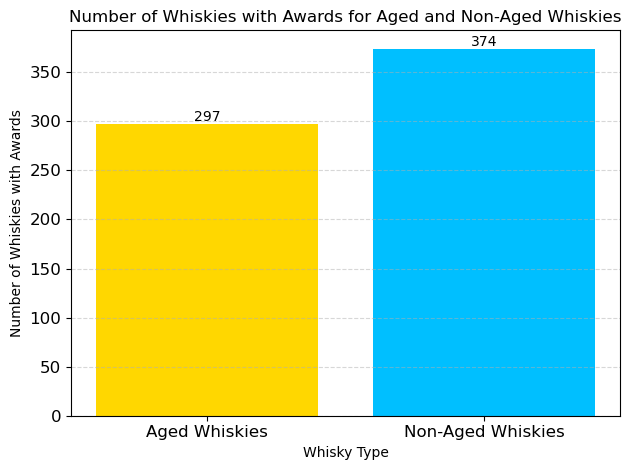

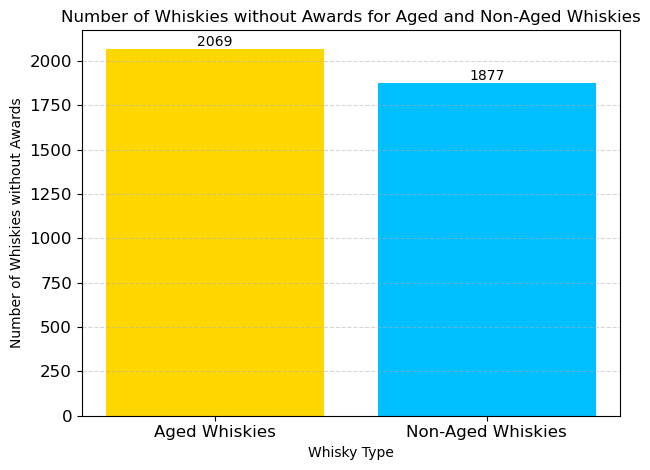

<AxesSubplot:>

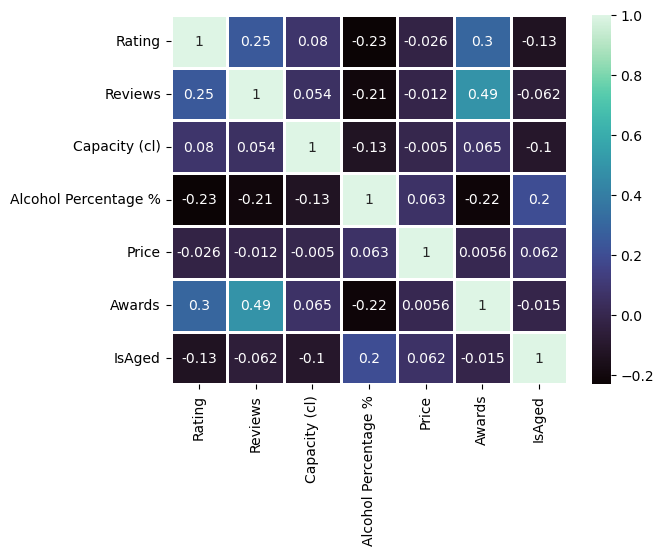

In [13]:
def update_aged_column(df_copy):
    def is_whisky_aged(name):
        if 'old' in name.lower():
            return 1
        else:
            return 0
    
    df_copy['IsAged'] = df_copy['Name'].apply(is_whisky_aged)
    df_copy.to_csv(file_path_copy, index=False)
    
    aged_whiskies = df_copy[df_copy['IsAged'] == 1]
    non_aged_whiskies = df_copy[df_copy['IsAged'] == 0]
    
    aged_whiskies_with_awards = aged_whiskies[aged_whiskies['Awards'] > 0]
    non_aged_whiskies_with_awards = non_aged_whiskies[non_aged_whiskies['Awards'] > 0]
    
    aged_whiskies_without_awards = aged_whiskies[aged_whiskies['Awards'] == 0]
    non_aged_whiskies_without_awards = non_aged_whiskies[non_aged_whiskies['Awards'] == 0]
    
    awards_counts = [
        len(aged_whiskies_with_awards),
        len(non_aged_whiskies_with_awards)
    ]
    
    no_awards_counts = [
        len(aged_whiskies_without_awards),
        len(non_aged_whiskies_without_awards)
    ]
    
    labels = ['Aged Whiskies', 'Non-Aged Whiskies']
    
    colors = ['#FFD700', '#00BFFF']  
    
    plt.bar(labels, awards_counts, color=colors)
    plt.xlabel('Whisky Type')
    plt.ylabel('Number of Whiskies with Awards')
    plt.title('Number of Whiskies with Awards for Aged and Non-Aged Whiskies')
    
    for i, count in enumerate(awards_counts):
        plt.text(i, count, str(count), ha='center', va='bottom')
    
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    
    plt.show()
    
    plt.bar(labels, no_awards_counts, color=colors)
    plt.xlabel('Whisky Type')
    plt.ylabel('Number of Whiskies without Awards')
    plt.title('Number of Whiskies without Awards for Aged and Non-Aged Whiskies')
    
    for i, count in enumerate(no_awards_counts):
        plt.text(i, count, str(count), ha='center', va='bottom')
    
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    
    plt.show()
def update_region_names(df_copy):
    
    country_mapping = {
        'Scotch': 'Scotland',
        'Islay': 'Scotland',
        'Speyside': 'Scotland',
        'Island': 'Scotland',
        'Highland': 'Scotland',
        'Campbeltown': 'Scotland',
        'Lowland': 'Scotland',
        'Finnish': 'Finland',
        'Japanese': 'Japan',
        'Irish Whiskey': 'Ireland',
        'Welsh': 'Wales',
        'Indian': 'India',
        'American Whiskey': 'United States',
        'English': 'England',
        'Canadian': 'Canada',
        'Other Scotch': 'Scotland',
        'Swedish': 'Sweden',
        'South African': 'South Africa',
        'Dutch Whiskies': 'Netherlands',
        'Taiwanese': 'Taiwan',
        'Israeli Whiskies': 'Israel',
        'Italian': 'Italy',
        'Kiwi': 'New Zealand',
        'Danish': 'Denmark'
    }
    
    df_copy['Region'] = df_copy['Region'].map(country_mapping).fillna(df_copy['Region'])
    df_copy.to_csv(file_path_copy, index=False)
    
    
extract_reviews_from_csv(file_path_copy)
df_copy = pd.read_csv(file_path_copy)
replace_empty_values(file_path_copy)
df_copy = pd.read_csv(file_path_copy)
extract_original_price(df_copy)
df_copy = pd.read_csv(file_path_copy)
Remove_Nan_in_PNF(file_path_copy)
df_copy = pd.read_csv(file_path_copy)
split_alcohol_percentage(file_path_copy)
df_copy = pd.read_csv(file_path_copy)
update_region_names(df_copy)
df_copy = pd.read_csv(file_path_copy)
update_aged_column(df_copy)
sns.heatmap(df_copy.corr(), annot=True,cmap="mako",linewidths=1)


####  Data Visualization



In [14]:
def plot_awards_vs_numerical_columns(df_copy):
    numerical_cols = ['Rating', 'Reviews', 'Capacity (cl)', 'Alcohol Percentage %', 'Price']

    fig, ax = plt.subplots(len(numerical_cols), 1, figsize=(10, 15))
    colors = sns.color_palette("Set2")

    for i, col in enumerate(numerical_cols):
        ax[i].scatter(df_copy['Awards'], df_copy[col], color=colors[i % len(colors)])
        ax[i].set_title('Awards vs ' + col, fontweight='bold')
        ax[i].set_xlabel('Awards')
        ax[i].set_ylabel(col)

    plt.tight_layout()
    plt.show()

sns.set(style='ticks')

def show_whiskey_awards(df_copy):
    categorical_columns = ['Region', 'Country']

    for column in categorical_columns:
        unique_categories = df_copy[column].nunique()
        figsize = ( unique_categories * 0.5, 10)
        plt.figure(figsize=figsize)
        ax = df_copy.groupby(column)['Awards'].value_counts().unstack().plot(kind='bar', stacked=True)
        plt.xlabel(column, fontsize=16)
        plt.ylabel('Count', fontsize=16)
        plt.title(f'Awards Distribution by {column}', fontsize=18)
        plt.xticks(rotation=90, fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(title='Awards', fontsize=12, bbox_to_anchor=(1.01, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
def create_reviews_scatter_plot(df_copy):
    fig, ax = plt.subplots()

    ax.plot(df_copy['Reviews'])
    ax.set_xlabel('Index')
    ax.set_ylabel('Price')
    ax.set_title('Reviews Variation')
    plt.show()
    
def create_price_scatter_plot(df_copy):
    df_copy_2 = df_copy.reset_index()

    fig, ax = plt.subplots()

    regions = df_copy_2['Region'].unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(regions)))  

    for region, color in zip(regions, colors):
        region_data = df_copy_2[df_copy_2['Region'] == region]
        ax.scatter(region_data.index, region_data['Price'], label=region, color=color, alpha=0.7)

    ax.set_xlabel('Index')
    ax.set_ylabel('Price')
    ax.set_title('Price Variation by Region')

    num_ticks = 10  
    step = len(df_copy_2.index) // num_ticks
    indices = df_copy_2.index[::step]  
    ax.set_xticks(indices)

    ax.set_ylim(50, 5000)

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    ax.grid(axis='both', linestyle='--', alpha=0.5)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    plt.show()
    
def plot_heatmap_by_region(dataframe, region_column):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    merged = world.merge(dataframe, left_on='name', right_on=region_column)
    fig, ax = plt.subplots(figsize=(15, 10))
    world[~world['name'].isin(merged[region_column])].plot(ax=ax, color='lightgrey')
    merged.plot(column=region_column, cmap='hot', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

    ax.set_title(f'Heatmap by {region_column}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.show()
    


def show_numerical_eda(df_copy, numerical_columns):
    for column in numerical_columns:
        unique_values = df_copy[column].unique()
        plt.figure(figsize=(10, 6))
        plt.hist(df_copy[column], bins=10)
        plt.xlabel(column, fontsize=16)
        plt.ylabel('Frequency', fontsize=16)
        plt.title(f'Distribution of {column}', fontsize=18)
        plt.xticks(unique_values, fontsize=12, rotation=90)
        plt.tight_layout()
        plt.show()

def Rating_dist_by_region(df_copy):
    sns.boxplot(x='Region', y='Rating', data=df_copy)
    plt.xlabel('Region')
    plt.ylabel('Rating')
    plt.title('Rating Distribution by Region')

    plt.xticks(rotation=90)

    plt.show()
  



<Figure size 1400x1000 with 0 Axes>

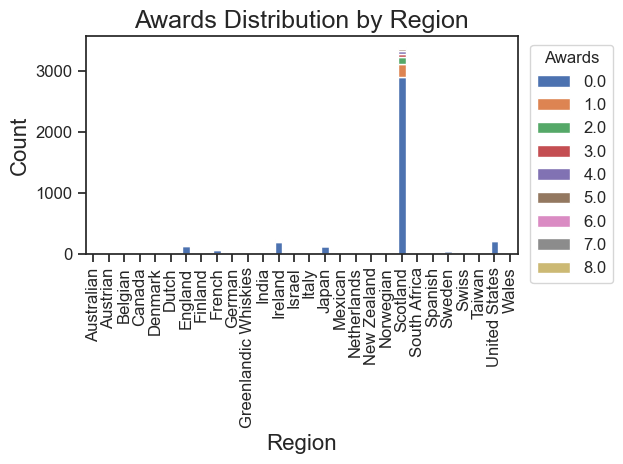

<Figure size 1400x1000 with 0 Axes>

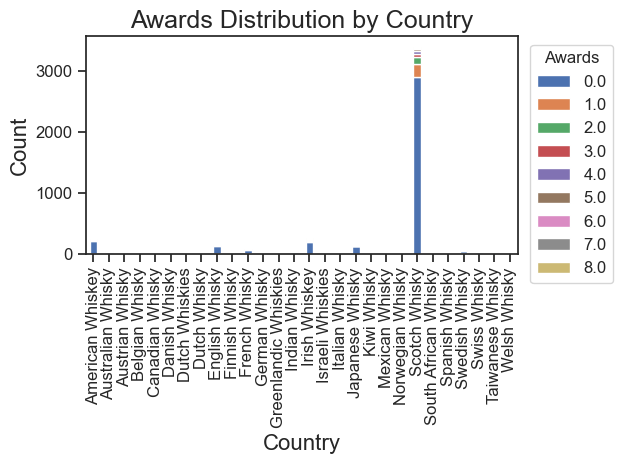

In [15]:
show_whiskey_awards(df_copy)


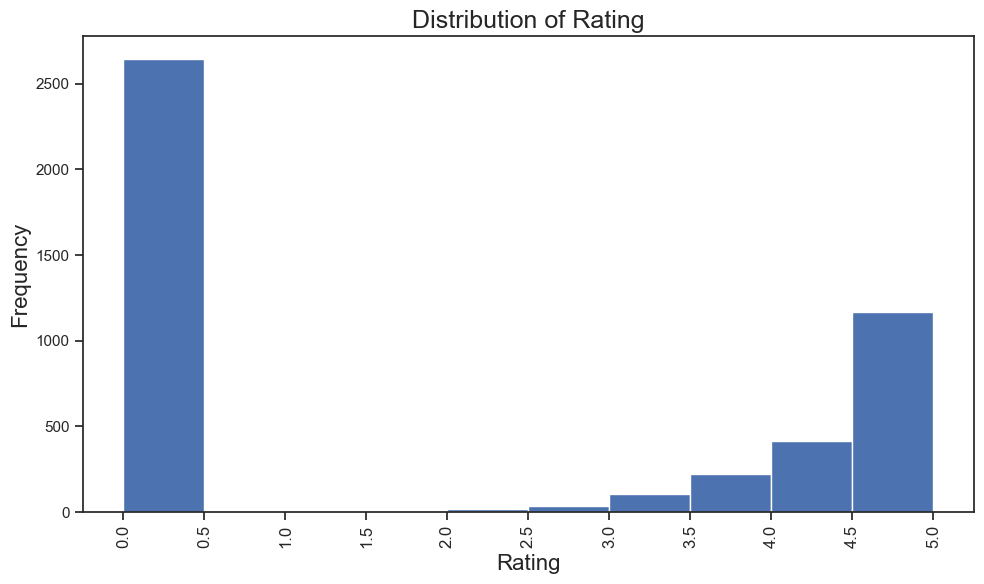

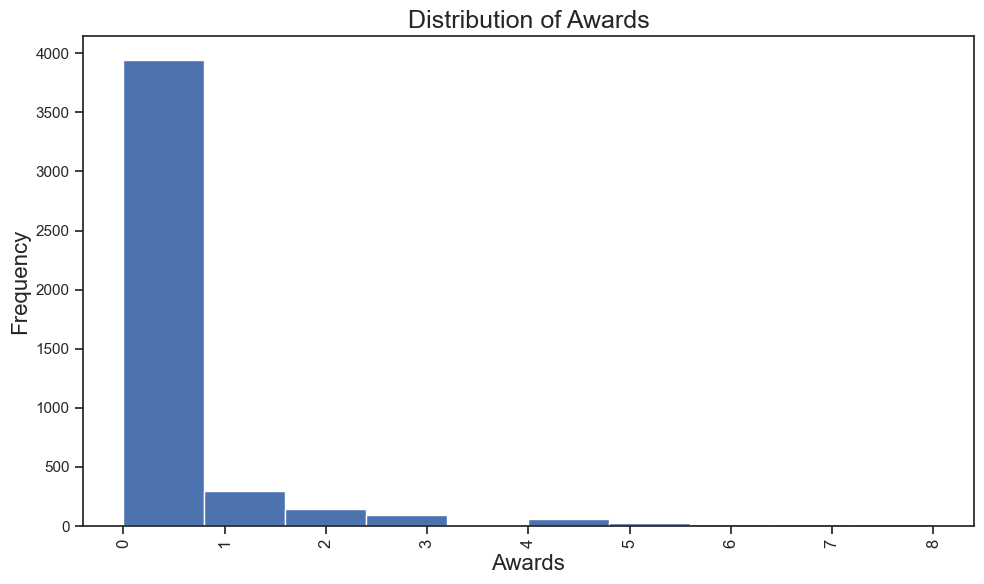

In [16]:
df_copy = pd.read_csv(file_path_copy)
numerical_columns = ['Rating', 'Awards']
show_numerical_eda(df_copy, numerical_columns)


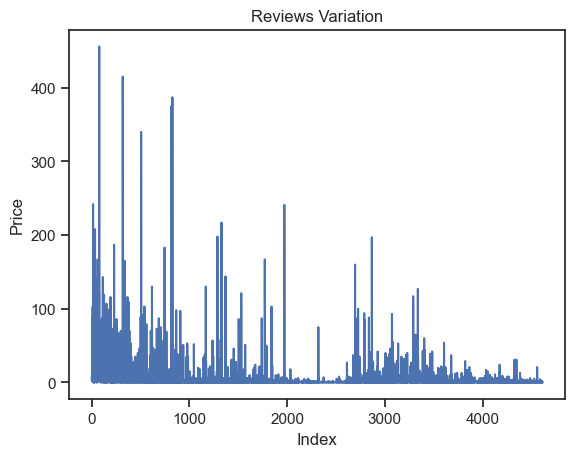

In [17]:
create_reviews_scatter_plot(df_copy)
df_copy = pd.read_csv(file_path_copy)


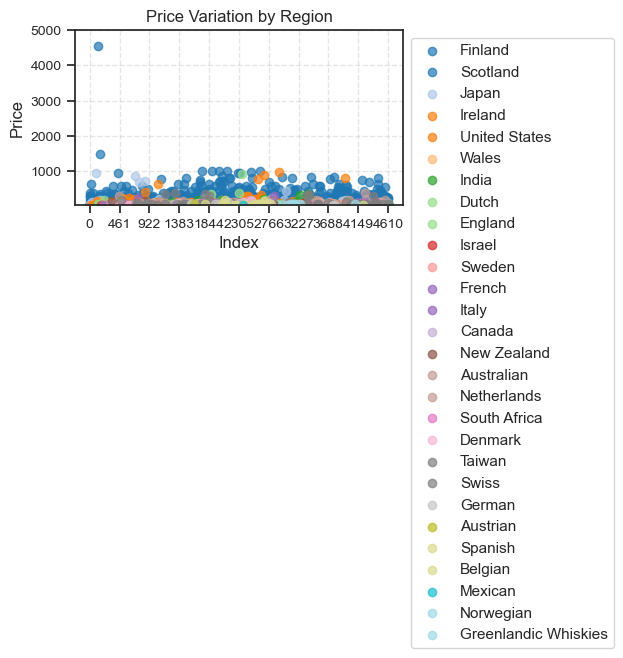

In [18]:
create_price_scatter_plot(df_copy)
df_copy = pd.read_csv(file_path_copy)


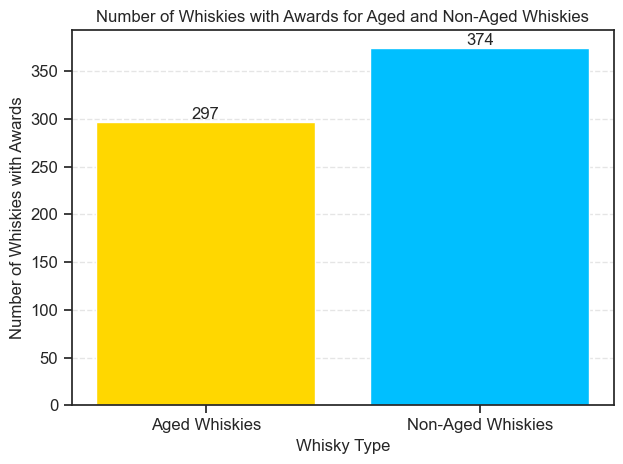

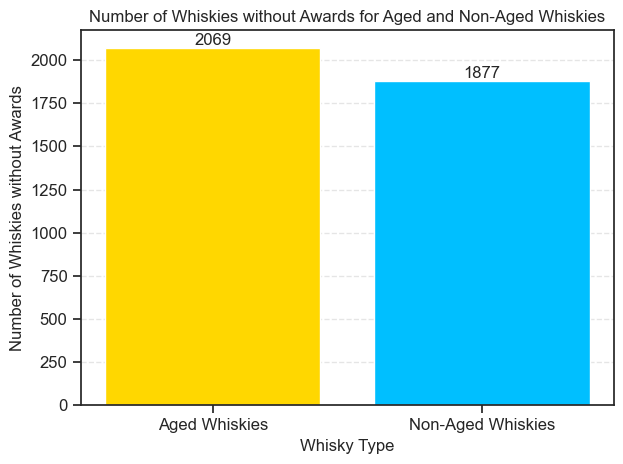

In [19]:
update_aged_column(df_copy)
df_copy = pd.read_csv(file_path_copy)


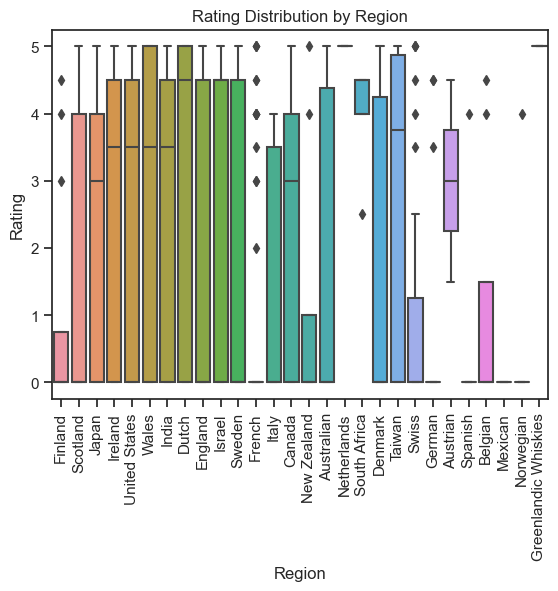

In [20]:
Rating_dist_by_region(df_copy)
df_copy = pd.read_csv(file_path_copy)


C:\Users\Chen\AppData\Local\Temp\ipykernel_19532\502481056.py:87: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


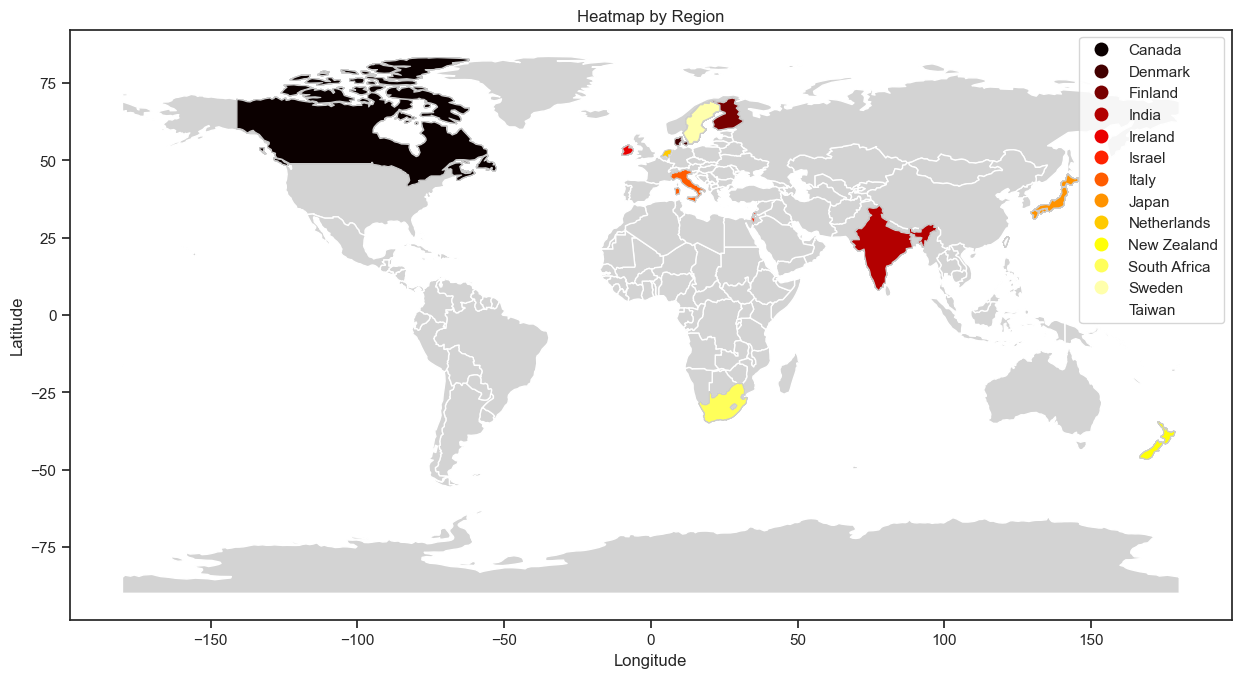

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4617 entries, 0 to 4616
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  4617 non-null   object 
 1   Distillery/Brand      4617 non-null   object 
 2   Region                4617 non-null   object 
 3   Bottler               4617 non-null   object 
 4   Country               4617 non-null   object 
 5   Rating                4617 non-null   float64
 6   Reviews               4617 non-null   float64
 7   Capacity (cl)         4617 non-null   int64  
 8   Alcohol Percentage %  4617 non-null   int64  
 9   Price                 4617 non-null   float64
 10  Awards                4617 non-null   float64
 11  Palate                4617 non-null   object 
 12  Finish                4617 non-null   object 
 13  Nose                  4617 non-null   object 
 14  Alcohol Percentage    4617 non-null   object 
 15  IsAged               

In [21]:
plot_heatmap_by_region(df_copy, 'Region')
df_copy.info()

# Machine Learning

After all the data exploration and visualization, we have gained a basic understanding of our whisky dataset, which allows us to address the question: Is it possible to predict the awards of a whisky?

To answer this question, we will build a machine learning module using different classification models. The models we will use are Logistic Regression, Random Forest, and Naive Bayes.

Before proceeding with the machine learning, we need to perform some additional data preprocessing. This involves encoding categorical variables such as 'Region', 'Bottler', and 'Country' using LabelEncoder to convert them into numeric form. We also need to scale the input features using MinMaxScaler to ensure all features are on a similar scale.

In [22]:
def create_classification_models(df_copy):
    categorical_cols = ["Region", "Bottler", "Country"]

    encoder = LabelEncoder()

    for col in categorical_cols:
        df_copy[col] = encoder.fit_transform(df_copy[col])

    X = df_copy[['Rating', 'Reviews', 'Capacity (cl)', 'Alcohol Percentage %', 'Price']]
    y = df_copy['Awards']

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    models = [
        LogisticRegression(solver='liblinear', max_iter=5000),
        RandomForestClassifier(),
        GaussianNB()
    ]

    model_names = ['Logistic Regression', 'Random Forest', 'Naive Bayes']
    accuracy_scores = []

    for model, model_name in zip(models, model_names):
        scores = cross_val_score(model, X_scaled, y, cv=5)

        accuracy = scores.mean()
        accuracy_scores.append(accuracy)

    plt.bar(model_names, accuracy_scores)
    plt.xlabel('Model')
    plt.ylabel('Accuracy Score')
    plt.title('Accuracy Scores for Different Classification Models')

    for i, score in enumerate(accuracy_scores):
        plt.text(i, score, f'{score:.2f}', ha='center', va='bottom')

    plt.ylim(0, 1.0)

    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()

    plt.show()

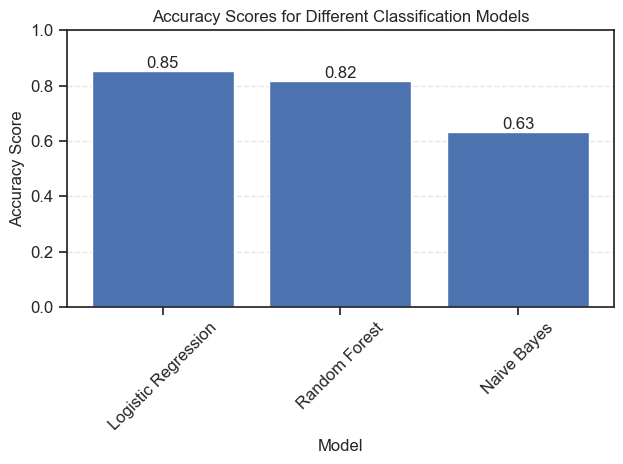

In [23]:
df_copy = pd.read_csv(file_path_copy)
create_classification_models(df_copy)

# Text Analyzing 
Provides insights into the most commonly used words in the dataset specifically for award-winning whiskies. It analyzes the text descriptions of these whiskies and predicts the frequencies of words, allowing us to identify the most frequently occurring words associated with award-winning whiskies.

In [25]:

def display_word_frequencies(df_train, df_test):
    clf_pipeline = create_simple_pipeline()

    X_train = df_train[['Nose', 'Palate', 'Finish']].astype(str)
    X_train = X_train.apply(lambda x: ' '.join(x.dropna()), axis=1)
    y_train = df_train['Awards']
    clf_pipeline.fit(X_train, y_train)
    
    X_test = df_test[['Nose', 'Palate', 'Finish']].astype(str)
    X_test = X_test.apply(lambda x: ' '.join(x.dropna()), axis=1)
    
    analyzed_text = clf_pipeline.named_steps['vectorizer'].transform(X_test)
    feature_names = clf_pipeline.named_steps['vectorizer'].get_feature_names_out()
    
    word_frequencies = np.asarray(analyzed_text.sum(axis=0)).squeeze()
    sorted_indices = np.argsort(word_frequencies)[::-1]
    
    stop_words = clf_pipeline.named_steps['vectorizer'].stop_words_
    filtered_indices = [i for i in sorted_indices if feature_names[i] not in stop_words]
    words = [feature_names[i] for i in filtered_indices]
    frequencies = word_frequencies[filtered_indices]
    word_freq_dict = dict(zip(words, frequencies))
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Frequencies in the Data (WordCloud)')
    plt.show()


Text used for fitting:
3189    Chocolate mousse, dates, a hint of honey lendi...
2646    Classic notes of caramel, toasty oak, tobacco,...
506     Good body with plenty of toasty oak, there are...
393     Sticky dried vine fruits and figs, with dark c...
1183    Honeyed malt with underlying lemon and apple, ...
                              ...                        
4426    Rich, fruity and nutty with notes of raisins a...
466     Cinnamon swirls and caramelised biscuits, haze...
3092    Rich wedding cake and espresso, cocoa, a littl...
3772    Ripe peaches, warm gingerbread, black forest h...
860     Classicly coastal with chalky grist, salty spr...
Length: 3693, dtype: object
Text used for prediction:
2264    Rich caramel, cinnamon, and clove join dense s...
1839    Creamy vanilla, acacia honey, orchard fruit, o...
2525    The peat is present immediately with notes of ...
23      Rich, powerful sherry with a well-integrated c...
1831    Red berry jam on toast, almond pastries and a

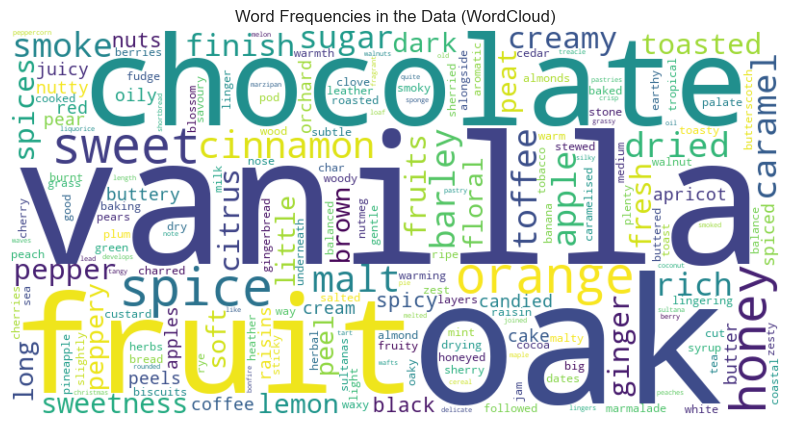

In [26]:
def create_simple_pipeline():
    extra_stop_words = set(['notes', 'touch', 'hint', 'hints'])
    stop_words = text.ENGLISH_STOP_WORDS.union(extra_stop_words)
    clf_pipeline = Pipeline([
        ('vectorizer', CountVectorizer(stop_words=stop_words, binary=True)),
        ('classifier', MultinomialNB())
    ])
    return clf_pipeline

def fit(clf_pipeline, df_train):
    X_train = df_train[['Nose', 'Palate', 'Finish']].astype(str)
    X_train = X_train.apply(lambda x: ' '.join(x.dropna()), axis=1)
    y_train = df_train['Awards']
    return clf_pipeline.fit(X_train, y_train)

def predict(clf_trained_pipeline, df_test):
    X_test = df_test[['Nose', 'Palate', 'Finish']].astype(str)
    X_test = X_test.apply(lambda x: ' '.join(x.dropna()), axis=1)
    return clf_trained_pipeline.predict(X_test)

def evaluate_accuracy(y_test, y_predicted):
    return accuracy_score(y_test, y_predicted)

df_train, df_test = train_test_split(df_copy, test_size=0.2, random_state=42)

clf_pipeline = create_simple_pipeline()

X_train = df_train[['Nose', 'Palate', 'Finish']].astype(str)
X_train = X_train.apply(lambda x: ' '.join(x.dropna()), axis=1)
y_train = df_train['Awards']
clf_pipeline.fit(X_train, y_train)
print("Text used for fitting:")
print(X_train)

X_test = df_test[['Nose', 'Palate', 'Finish']].astype(str)
X_test = X_test.apply(lambda x: ' '.join(x.dropna()), axis=1)
y_test = df_test['Awards']
y_predicted = clf_pipeline.predict(X_test)
print("Text used for prediction:")
print(X_test)

accuracy = evaluate_accuracy(y_test, y_predicted)
print("Accuracy:", accuracy)

analyzed_text = clf_pipeline.named_steps['vectorizer'].transform(X_test)
feature_names = clf_pipeline.named_steps['vectorizer'].get_feature_names_out()


display_word_frequencies(df_train, df_test)


# Conclusions

After we reaserched the data, cleaned the data, manipulated the data and used Machine Learning models, we concluded :The Regression Models showed us that after all of the things we did on the data we provided a 85% accuracy for predicting if a whisky will be an award Winner or not.
